In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
spark = SparkSession.builder.appName('Iteration').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/22 09:59:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/22 09:59:44 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
import pandas as pd

crime_data_pd=pd.read_excel("Crime.xlsx")
education_data_pd=pd.read_excel("Education.xlsx")

#Transfer pandas dataframe to spark dataframe
crime_data= spark.createDataFrame(crime_data_pd)
education_data= spark.createDataFrame(education_data_pd)

In [3]:
from pyspark.sql.functions import col, sum as spark_sum, isnan

def calculate_total_missing_values(dataframe):

    missing_counts = dataframe.select([
        (spark_sum(col(column).isNull().cast("int")) + spark_sum(isnan(col(column)).cast("int"))).alias(column)
        for column in dataframe.columns
    ])
    
    total_missing_values = missing_counts.select(
        [spark_sum(col(column)) for column in missing_counts.columns]
    ).first()

    return sum(total_missing_values)


total_missing_crime_data = calculate_total_missing_values(crime_data)
total_missing_education_data = calculate_total_missing_values(education_data)


print(f"Total missing values in crime_data: {total_missing_crime_data}")
print(f"Total missing values in education_data: {total_missing_education_data}")


Total missing values in crime_data: 16
Total missing values in education_data: 157


In [4]:
def calculate_mean_values(dataframe, exclude_columns):
    dataframe = dataframe.fillna(0)
    mean_values = dataframe.agg(
        *[avg(col(column)).alias(column) for column in dataframe.columns if column not in exclude_columns]
    ).first().asDict()
    return mean_values

def replace_missing_values_with_mean(dataframe, exclude_columns):
    mean_values = calculate_mean_values(dataframe, exclude_columns)
    dataframe = dataframe.fillna(mean_values)
    return dataframe


exclude_columns=["Region","Year"]

crime_data=replace_missing_values_with_mean(crime_data, exclude_columns)
education_data=replace_missing_values_with_mean(education_data, exclude_columns)


total_missing_crime_data_update=calculate_total_missing_values(crime_data)
total_missing_education_data_update=calculate_total_missing_values(education_data)

print(f"Total missing values in crime_data after dealing: {total_missing_crime_data_update}")
print(f"Total missing values in education_data after dealing: {total_missing_education_data_update}")

Total missing values in crime_data after dealing: 0
Total missing values in education_data after dealing: 0


In [5]:
from pyspark.sql.functions import round

education_data = education_data.withColumn(
    "Student Attendance",
    (col("Total amount of student attending regularly") / col("Total amount of Students") * 100).cast("double")
)

education_data = education_data.withColumn("Student Attendance", round(col("Student Attendance"), 1))

education_data = education_data.drop("Total amount of student attending regularly", "Total amount of Students")

education_data.show(20)

+--------------+----+-----------------------+---------------------+-----------------------------------------------+------------------+
|        Region|year|Total amount of schools|Mean household income|Participation in ECE(early childhood education)|Student Attendance|
+--------------+----+-----------------------+---------------------+-----------------------------------------------+------------------+
|     Northland|2014|                  151.0|              66248.0|                                         7028.0|              58.4|
|     Northland|2015|                  152.0|              68880.0|                                         6939.0|              60.7|
|     Northland|2016|                  152.0|              73469.0|                                         7200.0|              55.9|
|     Northland|2017|                  151.0|              75326.0|                                         7422.0|              50.9|
|     Northland|2018|                  151.0|          

In [6]:
Integrated_data = crime_data.join(education_data, on=["Region", "Year"], how="left")
Integrated_data.show()

+--------------+----+-----------------------------------+-------------------------------------+-----------------------------------+-----------------------------------------------------+------------------------------------+-----------------------+---------------------+-----------------------------------------------+------------------+
|        Region|year|Total amount of convicted juveniles|Total amount of family violence cases|Total amount of people with charges|Total amount of harmful digital communication offense|Total amount of drugs offences cases|Total amount of schools|Mean household income|Participation in ECE(early childhood education)|Student Attendance|
+--------------+----+-----------------------------------+-------------------------------------+-----------------------------------+-----------------------------------------------------+------------------------------------+-----------------------+---------------------+-----------------------------------------------+------------

In [7]:
#4.1.1 Feature Selection, choose four of most significant fields for target variables
from pyspark.ml.feature import VectorAssembler, UnivariateFeatureSelector
from pyspark.sql.functions import col


Copy_data = Integrated_data


useless_columns = ['Region', 'year', 'Total amount of convicted juveniles']
needed_columns = []

for column in Copy_data.columns:
    if column not in useless_columns:
        needed_columns.append(column)


features_combination = VectorAssembler(
    inputCols=needed_columns,
    outputCol='useful_features_list'
)


data_with_features = features_combination.transform(Copy_data)


features_selection = UnivariateFeatureSelector(
    featuresCol='useful_features_list',
    labelCol='Total amount of convicted juveniles',
    selectionMode='numTopFeatures'
)

features_selection.setFeatureType('continuous').setLabelType('continuous').setSelectionThreshold(4)


model = features_selection.fit(data_with_features)


selected_indices = model.selectedFeatures

for indices in selected_indices:
    print(needed_columns[indices])

    
selected_feature_names = [needed_columns[i] for i in selected_indices]
    
Final_data = Integrated_data.select(['Region', 'year', 'Total amount of convicted juveniles'] + selected_feature_names)

Final_data.show()

Total amount of family violence cases
Total amount of people with charges
Total amount of drugs offences cases
Mean household income
+--------------+----+-----------------------------------+-------------------------------------+-----------------------------------+------------------------------------+---------------------+
|        Region|year|Total amount of convicted juveniles|Total amount of family violence cases|Total amount of people with charges|Total amount of drugs offences cases|Mean household income|
+--------------+----+-----------------------------------+-------------------------------------+-----------------------------------+------------------------------------+---------------------+
|South Auckland|2015|                                297|                                 1484|                              10484|                                 565|    64268.58564814815|
|      Auckland|2016|                                 87|                                  961|        

In [8]:
#4.2 Data reduction, delete those useless regions
Final_data.filter(col('Region') == 'East Coast').show()

Final_data.filter(col('Region') == 'South Auckland').show()

Final_data.show()

useless_regions=['Northern Wellington','East Coast','Waiariki','Waitematā']
Final_data=Final_data.filter(~Final_data['Region'].isin(useless_regions))


print("The count of data after data reduction:{}".format(Final_data.count()))

+----------+----+-----------------------------------+-------------------------------------+-----------------------------------+------------------------------------+---------------------+
|    Region|year|Total amount of convicted juveniles|Total amount of family violence cases|Total amount of people with charges|Total amount of drugs offences cases|Mean household income|
+----------+----+-----------------------------------+-------------------------------------+-----------------------------------+------------------------------------+---------------------+
|East Coast|2014|                                150|                                 1080|                               5362|                                 380|    64268.58564814815|
|East Coast|2015|                                150|                                 1162|                               5097|                                 357|    64268.58564814815|
|East Coast|2016|                                153|            

The count of data after data reduction:108


['Total amount of family violence cases', 'Total amount of people with charges', 'Total amount of drugs offences cases', 'Mean household income']
root
 |-- Region: string (nullable = true)
 |-- year: long (nullable = true)
 |-- Total amount of convicted juveniles: long (nullable = true)
 |-- Total amount of family violence cases: long (nullable = true)
 |-- Total amount of people with charges: long (nullable = true)
 |-- Total amount of drugs offences cases: long (nullable = true)
 |-- Mean household income: double (nullable = true)
 |-- features: vector (nullable = true)

+--------------------+-----------------------------------+
|            features|Total amount of convicted juveniles|
+--------------------+-----------------------------------+
|[1104.0,5758.0,45...|                                162|
|[1142.0,7797.0,48...|                                153|
|[713.0,3030.0,234...|                                 57|
|[1584.0,9366.0,58...|                                201|
|[1129.

24/05/22 10:00:05 WARN Instrumentation: [acbe6c62] regParam is zero, which might cause numerical instability and overfitting.
24/05/22 10:00:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/22 10:00:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
24/05/22 10:00:05 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Coefficients: [-0.0035224665820982244,0.02241725411506229,-0.052536603535462634,-0.0007398693922971174] Intercept: 82.89121371997378


24/05/22 10:00:08 WARN Instrumentation: [70b07c54] regParam is zero, which might cause numerical instability and overfitting.


Coefficients: [-0.001964837438090662,0.02821333829705959,-0.09105776025005302,-0.0001420231572291655] Intercept: 16.355798297581273


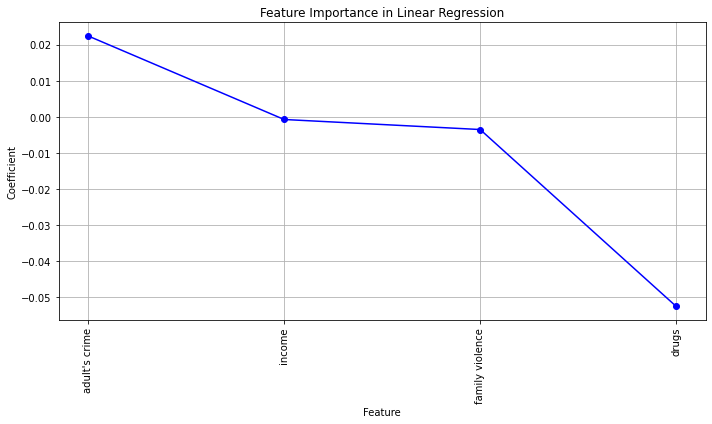

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+
|           residuals|
+--------------------+
|  2.1418066947015895|
|  12.408108636659279|
| -15.215580397575707|
| -1.5419094107827718|
| -10.386688450720833|
|  -1.911463175160879|
|0.008049714030384791|
|  11.490631466106265|
|   4.400143752329704|
|    -5.5678900841949|
| -19.921224498966552|
| -15.478826925272593|
|  -22.32903893474355|
|   4.046460482528907|
| -14.589318147113744|
| -19.778557094808058|
|  -28.04968079238548|
| -12.425529862417179|
|   6.509817942230974|
|   4.520551446761502|
+--------------------+
only showing top 20 rows

RSME: 23.406821939521198
R2: 0.8051778570946788


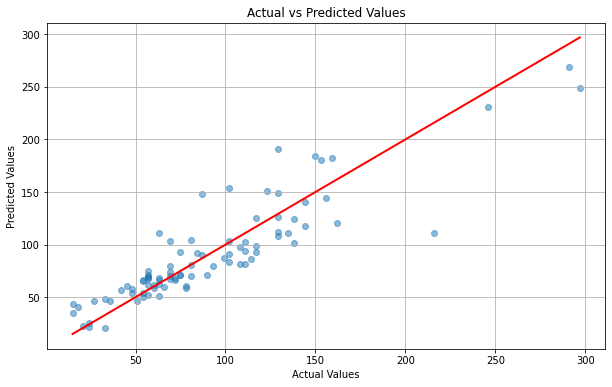

In [9]:
#6/7 Linear Regression, find out coefficient for each field

from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler


columns_list = Final_data.columns
useless_columns = ['Region', 'year', 'Total amount of convicted juveniles']
needed_features = []

for column in columns_list:
    if column not in useless_columns:
        needed_features.append(column)

print(needed_features)


features_combination = VectorAssembler(
    inputCols=needed_features,
    outputCol='features'
)


data_with_features = features_combination.transform(Final_data)

data_with_features.printSchema()

research_data_1=data_with_features.select('features','Total amount of convicted juveniles')
research_data_1.show()

train_data_1,test_data_1 = research_data_1.randomSplit([0.2,0.8],seed=42)


r1 = LinearRegression(labelCol='Total amount of convicted juveniles')
r1_training = r1.fit(train_data_1)
print("Coefficients: {} Intercept: {}".format(r1_training.coefficients,r1_training.intercept))
train_results =r1_training.evaluate(train_data_1)

r1_testing=r1.fit(test_data_1)
print("Coefficients: {} Intercept: {}".format(r1_testing.coefficients,r1_testing.intercept))
test_results =r1_testing.evaluate(test_data_1)


#8.2 Data visualisation
import matplotlib.pyplot as plt

coefficients = r1_training.coefficients.toArray()
label_name=["family violence","adult's crime","drugs","income"]
features_importance = pd.DataFrame(list(zip(label_name, coefficients)), columns=['Feature', 'Coefficient'])
features_importance = features_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.plot(features_importance['Feature'], features_importance['Coefficient'], marker='o', linestyle='-', color='blue')
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Importance in Linear Regression')
plt.grid(True)
plt.tight_layout()
plt.show()



#8.2/8.3 evaluation and data visualisation of evaluation

import matplotlib.pyplot as plt

test_results.residuals.show()
print("RSME: {}".format(test_results.rootMeanSquaredError))

print("R2: {}".format(test_results.r2))

predictions_1 = test_results.predictions.select('prediction', 'Total amount of convicted juveniles').toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_1['Total amount of convicted juveniles'], predictions_1['prediction'], alpha=0.5)
plt.plot([predictions_1['Total amount of convicted juveniles'].min(), predictions_1['Total amount of convicted juveniles'].max()],
         [predictions_1['Total amount of convicted juveniles'].min(), predictions_1['Total amount of convicted juveniles'].max()],
         color='red', lw=2)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()

['Total amount of family violence cases', 'Total amount of people with charges', 'Total amount of drugs offences cases', 'Mean household income']
root
 |-- Region: string (nullable = true)
 |-- year: long (nullable = true)
 |-- Total amount of convicted juveniles: long (nullable = true)
 |-- Total amount of family violence cases: long (nullable = true)
 |-- Total amount of people with charges: long (nullable = true)
 |-- Total amount of drugs offences cases: long (nullable = true)
 |-- Mean household income: double (nullable = true)
 |-- features: vector (nullable = true)

+--------------------+-----------------------------------+
|            features|Total amount of convicted juveniles|
+--------------------+-----------------------------------+
|[1104.0,5758.0,45...|                                162|
|[1142.0,7797.0,48...|                                153|
|[713.0,3030.0,234...|                                 57|
|[1584.0,9366.0,58...|                                201|
|[1129.

24/05/22 10:00:14 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 20 (= number of training instances)


                                 Feature  Importance
0  Total amount of family violence cases    0.718746
1    Total amount of people with charges    0.191764
2   Total amount of drugs offences cases    0.062314
3                  Mean household income    0.027176


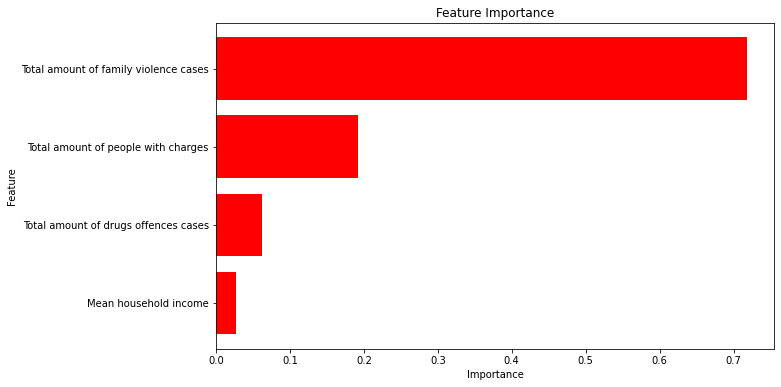

Root Mean Squared Error (RMSE) on test data = 34.492958767630455


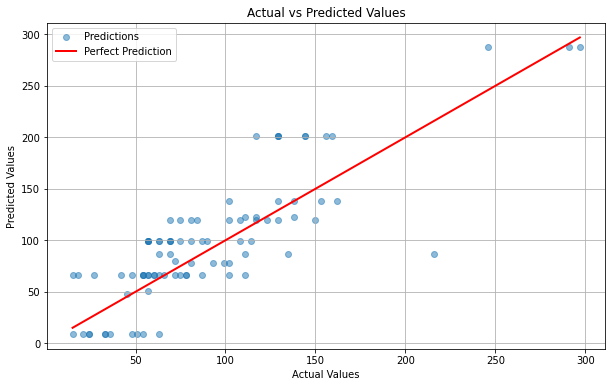

Learned regression tree model:
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_54c7408600b6, depth=5, numNodes=31, numFeatures=4
  If (feature 0 <= 1011.5)
   If (feature 0 <= 666.0)
    If (feature 0 <= 444.5)
     Predict: 9.0
    Else (feature 0 > 444.5)
     If (feature 2 <= 167.5)
      If (feature 0 <= 477.5)
       Predict: 48.0
      Else (feature 0 > 477.5)
       Predict: 51.0
     Else (feature 2 > 167.5)
      Predict: 66.0
   Else (feature 0 > 666.0)
    If (feature 3 <= 108533.5)
     If (feature 1 <= 4101.0)
      If (feature 0 <= 820.0)
       Predict: 99.0
      Else (feature 0 > 820.0)
       Predict: 78.0
     Else (feature 1 > 4101.0)
      If (feature 0 <= 850.0)
       Predict: 123.0
      Else (feature 0 > 850.0)
       Predict: 120.0
    Else (feature 3 > 108533.5)
     If (feature 1 <= 6810.0)
      If (feature 0 <= 854.0)
       Predict: 79.5
      Else (feature 0 > 854.0)
       Predict: 87.0
     Else (feature 1 > 6810.0)
      Predict: 66.0
  Else (f

In [10]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler


columns_list = Final_data.columns
useless_columns = ['Region', 'year', 'Total amount of convicted juveniles']
needed_features = []

for column in columns_list:
    if column not in useless_columns:
        needed_features.append(column)

print(needed_features)


features_combination = VectorAssembler(
    inputCols=needed_features,
    outputCol='features'
)


data_with_features = features_combination.transform(Final_data)

data_with_features.printSchema()

research_data_2=data_with_features.select('features','Total amount of convicted juveniles')
research_data_2.show()

train_data_2,test_data_2 = research_data_2.randomSplit([0.2,0.8],seed=42)

d1 = DecisionTreeRegressor(labelCol='Total amount of convicted juveniles', featuresCol='features',maxDepth=5,seed=79)

d1_model = d1.fit(train_data_2)

#8.2 Data visualisation

feature_importances_2 = d1_model.featureImportances.toArray()

feature_names_2 = needed_features

importances_df_2 = pd.DataFrame({
    'Feature': feature_names_2,
    'Importance': feature_importances_2
})

importances_df_2 = importances_df_2.sort_values(by='Importance', ascending=False)

print(importances_df_2)

plt.figure(figsize=(10, 6))
plt.barh(importances_df_2['Feature'], importances_df_2['Importance'], color='red')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()



#8.2/8.3 evaluation and data visualisation of evaluation
predictions_test= d1_model.transform(test_data_2)

evaluator = RegressionEvaluator(
    labelCol='Total amount of convicted juveniles', predictionCol='prediction', metricName='rmse'
)

test_rmse_1 = evaluator.evaluate(predictions_test)
print(f"Root Mean Squared Error (RMSE) on test data = {test_rmse_1}")

predictions_test_pd = predictions_test.select('prediction', 'Total amount of convicted juveniles').toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_test_pd['Total amount of convicted juveniles'], predictions_test_pd['prediction'], alpha=0.5, label='Predictions')
plt.plot([predictions_test_pd['Total amount of convicted juveniles'].min(), predictions_test_pd['Total amount of convicted juveniles'].max()],
         [predictions_test_pd['Total amount of convicted juveniles'].min(), predictions_test_pd['Total amount of convicted juveniles'].max()],
         color='red', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

print(f"Learned regression tree model:\n{d1_model.toDebugString}")




['Total amount of family violence cases', 'Total amount of people with charges', 'Total amount of drugs offences cases', 'Mean household income']
root
 |-- Region: string (nullable = true)
 |-- year: long (nullable = true)
 |-- Total amount of convicted juveniles: long (nullable = true)
 |-- Total amount of family violence cases: long (nullable = true)
 |-- Total amount of people with charges: long (nullable = true)
 |-- Total amount of drugs offences cases: long (nullable = true)
 |-- Mean household income: double (nullable = true)
 |-- features: vector (nullable = true)

+--------------------+-----------------------------------+
|            features|Total amount of convicted juveniles|
+--------------------+-----------------------------------+
|[1104.0,5758.0,45...|                                162|
|[1142.0,7797.0,48...|                                153|
|[713.0,3030.0,234...|                                 57|
|[1584.0,9366.0,58...|                                201|
|[1129.

24/05/22 10:00:18 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 20 (= number of training instances)


                                 Feature  Importance
0  Total amount of family violence cases    0.387624
1    Total amount of people with charges    0.318874
2   Total amount of drugs offences cases    0.176578
3                  Mean household income    0.116924


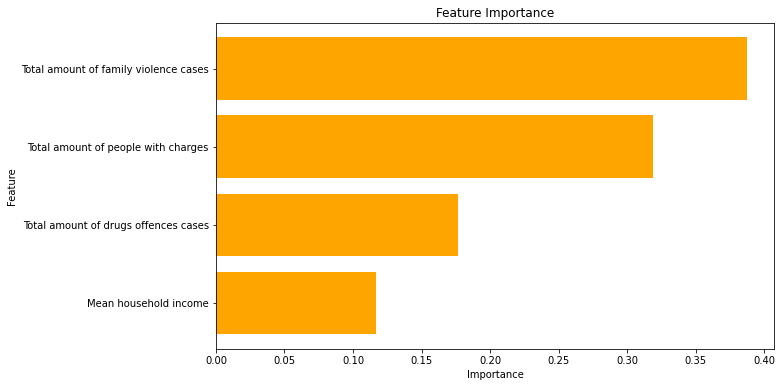

Root Mean Squared Error (RMSE) on test data = 27.901899559107445


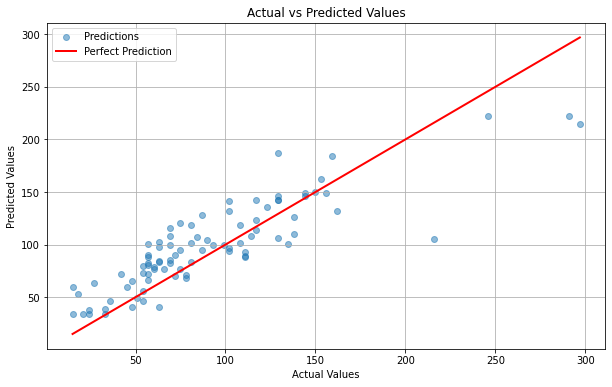

In [11]:
#6/7 Random Forest
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler


columns_list = Final_data.columns
useless_columns = ['Region', 'year', 'Total amount of convicted juveniles']
needed_features = []

for column in columns_list:
    if column not in useless_columns:
        needed_features.append(column)

print(needed_features)


features_combination = VectorAssembler(
    inputCols=needed_features,
    outputCol='features'
)


data_with_features = features_combination.transform(Final_data)

data_with_features.printSchema()

research_data_3=data_with_features.select('features','Total amount of convicted juveniles')
research_data_3.show()

train_data_3,test_data_3 = research_data_3.randomSplit([0.2,0.8],seed=42)

rf=RandomForestRegressor(labelCol='Total amount of convicted juveniles', featuresCol='features',numTrees=100, maxDepth=5, seed=79)

rf_model = rf.fit(train_data_3)

#8.2 Data visualisation

feature_importances_3 = rf_model.featureImportances.toArray()

feature_names_3 = needed_features

importances_df_3 = pd.DataFrame({
    'Feature': feature_names_3,
    'Importance': feature_importances_3
})

importances_df_3 = importances_df_3.sort_values(by='Importance', ascending=False)

print(importances_df_3)

plt.figure(figsize=(10, 6))
plt.barh(importances_df_3['Feature'], importances_df_3['Importance'], color='orange')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


#8.2/8.3 evaluation and data visualisation of evaluation
predictions_test_2=rf_model.transform(test_data_3)

test_rmse_2 = evaluator.evaluate(predictions_test_2)

print(f"Root Mean Squared Error (RMSE) on test data = {test_rmse_2}")

evaluator = RegressionEvaluator(
    labelCol='Total amount of convicted juveniles', predictionCol='prediction', metricName='rmse'
)

predictions_test_2_pd = predictions_test_2.select('prediction', 'Total amount of convicted juveniles').toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_test_2_pd['Total amount of convicted juveniles'], predictions_test_2_pd['prediction'], alpha=0.5, label='Predictions')
plt.plot([predictions_test_2_pd['Total amount of convicted juveniles'].min(), predictions_test_2_pd['Total amount of convicted juveniles'].max()],
         [predictions_test_2_pd['Total amount of convicted juveniles'].min(), predictions_test_2_pd['Total amount of convicted juveniles'].max()],
         color='red', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
